In [ ]:
from google.colab import files
import io
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.mixture import GaussianMixture
from pylab import concatenate, normal
from scipy.stats import ks_2samp
from datetime import date

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['owid-covid-data.csv']))

Saving owid-covid-data.csv to owid-covid-data (1).csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['owid-covid-data.csv']))

In [ ]:
df=df.fillna(0)
df_ind = df.loc[df["location"] == "India"]
df_sa = df.loc[df["location"] == "South Africa"]
df_zim = df.loc[df["location"] == "Zimbabwe"]
df_ind=df_ind.iloc[:,[3,5]]
df_sa=df_sa.iloc[:,[3,5]]
df_zim=df_zim.iloc[:,[3,5]]

In [ ]:
df_zim=df_zim.iloc[:600,:]
df_sa=df_sa.iloc[:650,:]

In [ ]:
df_ind.reset_index(inplace=True,drop=True)
df_zim.reset_index(inplace=True,drop=True)
df_sa.reset_index(inplace=True,drop=True)

In [ ]:
m,d,y=df_ind.iloc[0,0].split("/")
date0=date(int(y),int(m),int(d))
for i in range(df_ind.index.max()+1):
  m1,d1,y1=df_ind.iloc[i,0].split("/")
  date1=date(int(y1),int(m1),int(d1))
  df_ind.iloc[i,0]=(date1-date0).days
  if df_ind.iloc[i,1]==0:
    df_ind.iloc[i,1]=(df_ind.iloc[i-1,1]+df_ind.iloc[i+1,1])/2
df_ind['new_cases']=df_ind['new_cases'].astype(int)

m,d,y=df_sa.iloc[0,0].split("/")
date0=date(int(y),int(m),int(d))
for i in range(df_sa.index.max()+1):
  m1,d1,y1=df_sa.iloc[i,0].split("/")
  date1=date(int(y1),int(m1),int(d1))
  df_sa.iloc[i,0]=(date1-date0).days
  if df_sa.iloc[i,1]==0:
    df_sa.iloc[i,1]=(df_sa.iloc[i-1,1]+df_sa.iloc[i+1,1])/2
df_sa['new_cases']=df_sa['new_cases'].astype(int)

m,d,y=df_zim.iloc[0,0].split("/")
date0=date(int(y),int(m),int(d))
for i in range(df_zim.index.max()+1):
  m1,d1,y1=df_zim.iloc[i,0].split("/")
  date1=date(int(y1),int(m1),int(d1))
  df_zim.iloc[i,0]=(date1-date0).days
  if df_zim.iloc[i,1]==0:
    df_zim.iloc[i,1]=df_zim.iloc[i+1,1]/2
    df_zim.iloc[i+1,1]=df_zim.iloc[i+1,1]-df_zim.iloc[i,1]
df_zim['new_cases']=df_zim['new_cases'].astype(int)

arr_ind=np.array([0])
arr_ind=arr_ind.reshape(-1,1)
arr_ind0=np.array(df_ind)
lim=df_ind.index.max()+1
for i in range(1,lim):
  if df_ind.iloc[i,1]==0:
    df_ind.iloc[i,1]=(df_ind.iloc[i-1,1]+df_ind.iloc[i+1,1])/2
  day=arr_ind0[i][0]
  num_cases=arr_ind0[i][1]
  arr_ind=np.vstack((arr_ind,np.full((num_cases,1),day)))

arr_sa=np.array([0])
arr_sa=arr_sa.reshape(-1,1)
arr_sa0=np.array(df_sa)
lim=df_sa.index.max()+1
for i in range(1,lim):
  day=arr_sa0[i][0]
  num_cases=arr_sa0[i][1]
  arr_sa=np.vstack((arr_sa,np.full((num_cases,1),day)))

arr_zim=np.array([0])
arr_zim=arr_zim.reshape(-1,1)
arr_zim0=np.array(df_zim)
lim=df_zim.index.max()+1
for i in range(1,lim):
  day=arr_zim0[i][0]
  num_cases=arr_zim0[i][1]
  arr_zim=np.vstack((arr_zim,np.full((num_cases,1),day)))

[[1.36466722]]


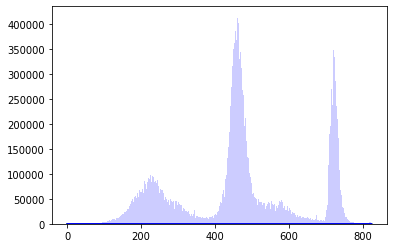

In [ ]:
ms=[232.37,460.27,553.03,722.86]
ms=np.array(ms)
ms=ms.reshape(4,1)
g=GaussianMixture(n_components=4, random_state=0,means_init=ms).fit(arr_ind)

n, bins, patches = plt.hist(arr_ind, df_ind['new_cases'].size, facecolor='blue', alpha=0.2)
x = np.linspace(df_ind['date'].min(),df_ind['date'].max(),200).reshape(200,1)

Y1 = arr_ind.size*g.weights_[0]*stats.norm.pdf(x,g.means_[0],np.sqrt(g.covariances_[0]))
Y2 = arr_ind.size*g.weights_[1]*stats.norm.pdf(x,g.means_[1],np.sqrt(g.covariances_[1]))
Y3 = arr_ind.size*g.weights_[3]*stats.norm.pdf(x,g.means_[3],np.sqrt(g.covariances_[3]))
Y2b = arr_ind.size*g.weights_[2]*stats.norm.pdf(x,g.means_[2],np.sqrt(g.covariances_[2]))

#plt.plot(x,Y1, c='red')
#plt.plot(x,Y2, c='green')
#plt.plot(x,Y3, c='blue')
#plt.plot(x,Y2b, c='pink')
#plt.plot(x, Y1+Y2+Y3+Y2b, c='black', alpha=0.2)

india_overall = Y1+Y2+Y3+Y2b
ior = Y1/max(Y1)+(Y2+Y2b)/max(Y2+Y2b)+Y3/max(Y3)

dist = (3*np.sqrt(g.covariances_[0]) + g.means_[3] - g.means_[0] + 3*np.sqrt(g.covariances_[3]))/500
print(dist)
#y1 = arr_ind.size*g.weights_[0]/dist*stats.norm.pdf(x,3*np.sqrt(g.covariances_[0])/dist,np.sqrt(g.covariances_[0])/dist)
#y2 = arr_ind.size*g.weights_[1]/dist*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[1]-g.means_[0])/dist,np.sqrt(g.covariances_[1])/dist)
#y3 = arr_ind.size*g.weights_[3]/dist*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[3]-g.means_[0])/dist,np.sqrt(g.covariances_[3])/dist)
#y2b = arr_ind.size*g.weights_[2]/dist*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[2]-g.means_[0])/dist,np.sqrt(g.covariances_[2])/dist)

y1 = 100*g.weights_[0]*stats.norm.pdf(x,3*np.sqrt(g.covariances_[0])/dist,np.sqrt(g.covariances_[0])/dist)
y2 = 100*g.weights_[1]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[1]-g.means_[0])/dist,np.sqrt(g.covariances_[1])/dist)
y3 = 100*g.weights_[3]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[3]-g.means_[0])/dist,np.sqrt(g.covariances_[3])/dist)
y2b = 100*g.weights_[2]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[2]-g.means_[0])/dist,np.sqrt(g.covariances_[2])/dist)

new_india_overall = y1+y2+y3+y2b
new_ior = y1/max(y1)+(y2+y2b)/max(y2+y2b) + y3/max(y3)
plt.plot(x,new_india_overall, c='green')
plt.plot(x,new_ior, c='blue')

[[1.07461155]]


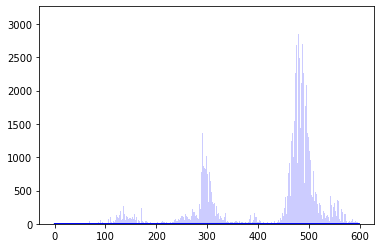

In [ ]:
ms=[139.873,257.044,299.802,482.366,499.212]
ms=np.array(ms)
ms=ms.reshape(5,1)
sum=0.059+0.032+0.169+0.307+0.194
ws=[0.059/sum,0.032/sum,0.169/sum,0.307/sum,0.194/sum]
ws=np.array(ws)
g=GaussianMixture(n_components=5, random_state=0,means_init=ms,weights_init=ws).fit(arr_zim)

n, bins, patches = plt.hist(arr_zim, df_zim['new_cases'].size, facecolor='blue', alpha=0.2)
x = np.linspace(df_zim['date'].min(),df_zim['date'].max(),200).reshape(200,1)

Y1 = arr_zim.size*g.weights_[0]*stats.norm.pdf(x,g.means_[0],np.sqrt(g.covariances_[0]))
Y2 = arr_zim.size*g.weights_[1]*stats.norm.pdf(x,g.means_[1],np.sqrt(g.covariances_[1]))
Y3 = arr_zim.size*g.weights_[2]*stats.norm.pdf(x,g.means_[2],np.sqrt(g.covariances_[2]))
Y4 = arr_zim.size*g.weights_[3]*stats.norm.pdf(x,g.means_[3],np.sqrt(g.covariances_[3]))
Y5 = arr_zim.size*g.weights_[4]*stats.norm.pdf(x,g.means_[4],np.sqrt(g.covariances_[4]))

#plt.plot(x,Y1, c='red')
#plt.plot(x,Y2+Y3, c='green')
#plt.plot(x,Y4+Y5, c='blue')
#plt.plot(x, Y1+Y2+Y3+Y4+Y5, c='black', alpha=0.2)

zim_overall = Y1+Y2+Y3+Y4+Y5
zor = Y1/max(Y1)+(Y2+Y3)/max(Y2+Y3)+(Y4+Y5)/max(Y4+Y5)

dist = (3*np.sqrt(g.covariances_[0]) + g.means_[4] - g.means_[0] + 3*np.sqrt(g.covariances_[3]))/500
print(dist)
#y1 = arr_zim.size/dist*g.weights_[0]*stats.norm.pdf(x,3*np.sqrt(g.covariances_[0])/dist,np.sqrt(g.covariances_[0])/dist)
#y2 = arr_zim.size/dist*g.weights_[1]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[1]-g.means_[0])/dist,np.sqrt(g.covariances_[1])/dist)
#y3 = arr_zim.size/dist*g.weights_[2]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[2]-g.means_[0])/dist,np.sqrt(g.covariances_[2])/dist)
#y4 = arr_zim.size/dist*g.weights_[3]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[3]-g.means_[0])/dist,np.sqrt(g.covariances_[3])/dist)
#y5 = arr_zim.size/dist*g.weights_[4]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[4]-g.means_[0])/dist,np.sqrt(g.covariances_[4])/dist)

y1 = 100*g.weights_[0]*stats.norm.pdf(x,3*np.sqrt(g.covariances_[0])/dist,np.sqrt(g.covariances_[0])/dist)
y2 = 100*g.weights_[1]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[1]-g.means_[0])/dist,np.sqrt(g.covariances_[1])/dist)
y3 = 100*g.weights_[2]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[2]-g.means_[0])/dist,np.sqrt(g.covariances_[2])/dist)
y4 = 100*g.weights_[3]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[3]-g.means_[0])/dist,np.sqrt(g.covariances_[3])/dist)
y5 = 100*g.weights_[4]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[4]-g.means_[0])/dist,np.sqrt(g.covariances_[4])/dist)

new_zim_overall = y1+y2+y3+y4+y5
new_zor = y1/max(y1)+(y2+y3)/max(y2+y3) + (y4+y5)/max(y4+y5)

plt.plot(x,new_zim_overall, c='green')
plt.plot(x,new_zor, c='blue')

[[1.24289448]]


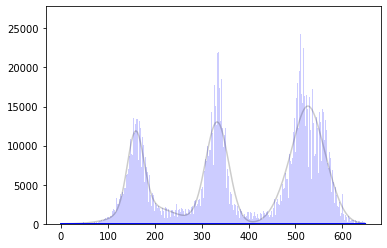

In [ ]:
ms=[145.41,164.50,332.79,506.20,538.45,566.85]
ms=np.array(ms)
ms=ms.reshape(6,1)
g=GaussianMixture(n_components=6, random_state=0,means_init=ms).fit(arr_sa)

n, bins, patches = plt.hist(arr_sa, df_sa['new_cases'].size, facecolor='blue', alpha=0.2)
x = np.linspace(df_sa['date'].min(),df_sa['date'].max(),200).reshape(200,1)

Y1 = arr_sa.size*g.weights_[0]*stats.norm.pdf(x,g.means_[0],np.sqrt(g.covariances_[0]))
Y1b = arr_sa.size*g.weights_[1]*stats.norm.pdf(x,g.means_[1],np.sqrt(g.covariances_[1]))
Y2 = arr_sa.size*g.weights_[2]*stats.norm.pdf(x,g.means_[2],np.sqrt(g.covariances_[2]))
Y3 = arr_sa.size*g.weights_[3]*stats.norm.pdf(x,g.means_[3],np.sqrt(g.covariances_[3]))
Y3b = arr_sa.size*g.weights_[4]*stats.norm.pdf(x,g.means_[4],np.sqrt(g.covariances_[4]))
Y3c = arr_sa.size*g.weights_[5]*stats.norm.pdf(x,g.means_[5],np.sqrt(g.covariances_[5]))

plt.plot(x, Y1+Y1b+Y2+Y3+Y3b+Y3c, c='black', alpha=0.2)
sa_overall = Y1+Y1b+Y2+Y3+Y3b+Y3c
saor = (Y1+Y1b)/max(Y1+Y1b)+Y2/max(Y2)+(Y3+Y3b+Y3c)/max(Y3+Y3b+Y3c)

dist = (3*np.sqrt(g.covariances_[0]) + g.means_[5] - g.means_[0] + 3*np.sqrt(g.covariances_[5]))/500
print(dist)
#y1 = arr_sa.size/dist*g.weights_[0]*stats.norm.pdf(x,3*np.sqrt(g.covariances_[0])/dist,np.sqrt(g.covariances_[0])/dist)
#y1b = arr_sa.size/dist*g.weights_[1]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[1]-g.means_[0])/dist,np.sqrt(g.covariances_[1])/dist)
#y2 = arr_sa.size/dist*g.weights_[2]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[2]-g.means_[0])/dist,np.sqrt(g.covariances_[2])/dist)
#y3 = arr_sa.size/dist*g.weights_[3]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[3]-g.means_[0])/dist,np.sqrt(g.covariances_[3])/dist)
#y3b = arr_sa.size/dist*g.weights_[4]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[4]-g.means_[0])/dist,np.sqrt(g.covariances_[4])/dist)
#y3c = arr_sa.size/dist*g.weights_[5]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[5]-g.means_[0])/dist,np.sqrt(g.covariances_[5])/dist)

y1 = 100*g.weights_[0]*stats.norm.pdf(x,3*np.sqrt(g.covariances_[0])/dist,np.sqrt(g.covariances_[0])/dist)
y1b = 100*g.weights_[1]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[1]-g.means_[0])/dist,np.sqrt(g.covariances_[1])/dist)
y2 = 100*g.weights_[2]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[2]-g.means_[0])/dist,np.sqrt(g.covariances_[2])/dist)
y3 = 100*g.weights_[3]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[3]-g.means_[0])/dist,np.sqrt(g.covariances_[3])/dist)
y3b = 100*g.weights_[4]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[4]-g.means_[0])/dist,np.sqrt(g.covariances_[4])/dist)
y3c = 100*g.weights_[5]*stats.norm.pdf(x,(3*np.sqrt(g.covariances_[0])+g.means_[5]-g.means_[0])/dist,np.sqrt(g.covariances_[5])/dist)

new_sa_overall = y1+y1b+y2+y3+y3b+y3c
new_saor = (y1+y1b)/max(y1) + y2/max(y2) + (y3+y3b+y3c)/max(y3+y3b+y3c)

plt.plot(x,new_sa_overall, c='green')
plt.plot(x,new_saor, c='blue')

In [ ]:
india_overall = np.ravel(india_overall)
zim_overall = np.ravel(zim_overall)
sa_overall = np.ravel(sa_overall)
ior = np.ravel(ior)
zor = np.ravel(zor)
saor = np.ravel(saor)

In [ ]:
print("Ind vs Zim : ",ks_2samp(india_overall, zim_overall))
print("Ind vs SA : ",ks_2samp(india_overall, sa_overall))
print("Ind vs Zim : ",ks_2samp(ior, zor))
print("Ind vs SA : ",ks_2samp(ior, saor))

Ind vs Zim :  Ks_2sampResult(statistic=0.81, pvalue=4.569224815484179e-66)
Ind vs SA :  Ks_2sampResult(statistic=0.63, pvalue=1.5506384306777397e-37)
Ind vs Zim :  Ks_2sampResult(statistic=0.105, pvalue=0.220541217580421)
Ind vs SA :  Ks_2sampResult(statistic=0.18, pvalue=0.0030098470801667434)


In [ ]:
print("Zim vs SA : ",mwu(zor, saor))

Zim vs SA :  MannwhitneyuResult(statistic=15968.0, pvalue=0.00024421252526040386)


In [ ]:
from scipy.stats import epps_singleton_2samp as epps
print("Ind vs Zim : ",epps(india_overall, zim_overall))
print("Ind vs SA : ",epps(india_overall, sa_overall))
print("Ind vs Zim : ",epps(ior, zor))
print("Ind vs SA : ",epps(ior, saor))

Ind vs Zim :  Epps_Singleton_2sampResult(statistic=437.1370190464931, pvalue=2.621032765206613e-93)
Ind vs SA :  Epps_Singleton_2sampResult(statistic=242.77449849726804, pvalue=2.3438167396353172e-51)
Ind vs Zim :  Epps_Singleton_2sampResult(statistic=2.3826036083298954, pvalue=0.6657733339297436)
Ind vs SA :  Epps_Singleton_2sampResult(statistic=5.847574814393735, pvalue=0.21082433147189003)


In [ ]:
from scipy.stats import mannwhitneyu as mwu
print("Ind vs Zim : ",mwu(india_overall, zim_overall))
print("Ind vs SA : ",mwu(india_overall, sa_overall))
print("Ind vs Zim : ",mwu(ior, zor))
print("Ind vs SA : ",mwu(ior, saor))

Ind vs Zim :  MannwhitneyuResult(statistic=1888.0, pvalue=1.302903948189181e-55)
Ind vs SA :  MannwhitneyuResult(statistic=7302.0, pvalue=2.315987305358855e-28)
Ind vs Zim :  MannwhitneyuResult(statistic=18325.0, pvalue=0.07375956308917317)
Ind vs SA :  MannwhitneyuResult(statistic=17457.0, pvalue=0.013934610013111165)


In [ ]:
from scipy.stats import brunnermunzel as bmz
print("Ind vs Zim : ",bmz(india_overall, zim_overall))
print("Ind vs SA : ",bmz(india_overall, sa_overall))
print("Ind vs Zim : ",bmz(ior, zor))
print("Ind vs SA : ",bmz(ior, saor))

Ind vs Zim :  BrunnerMunzelResult(statistic=-40.081831784606095, pvalue=6.308437116673605e-106)
Ind vs SA :  BrunnerMunzelResult(statistic=-13.825291317555747, pvalue=3.337793346683606e-32)
Ind vs Zim :  BrunnerMunzelResult(statistic=-1.4483872138711573, pvalue=0.14829878660773982)
Ind vs SA :  BrunnerMunzelResult(statistic=2.208950409472715, pvalue=0.027749401154960607)


In [ ]:
from scipy.stats import anderson_ksamp as adt
print("Ind vs Zim : ",adt([india_overall, zim_overall]))
print("Ind vs SA : ",adt([india_overall, sa_overall]))
print("Ind vs Zim : ",adt([ior, zor]))
print("Ind vs SA : ",adt([ior, saor]))

Ind vs Zim :  Anderson_ksampResult(statistic=165.0537039342299, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)
Ind vs SA :  Anderson_ksampResult(statistic=87.94890966606297, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.001)
Ind vs Zim :  Anderson_ksampResult(statistic=1.0321404678898727, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.12257710310702745)
Ind vs SA :  Anderson_ksampResult(statistic=2.8597348021209004, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.022099388417538595)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: p-value floored: true value smaller than 0.001
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: p-value floored: true value smaller than 0.001
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
from scipy.stats import kruskal
print("Ind vs Zim : ",kruskal(india_overall, zim_overall))
print("Ind vs SA : ",kruskal(india_overall, sa_overall))
print("Ind vs Zim : ",kruskal(ior, zor))
print("Ind vs SA : ",kruskal(ior, saor))

Ind vs Zim :  KruskalResult(statistic=245.41985835411447, pvalue=2.5881424183612826e-55)
Ind vs SA :  KruskalResult(statistic=120.62783341645877, pvalue=4.60984727548497e-28)
Ind vs Zim :  KruskalResult(statistic=2.0989713216956716, pvalue=0.1473982756023858)
Ind vs SA :  KruskalResult(statistic=4.838041645885141, pvalue=0.02783849178699295)


In [ ]:
new_india_overall = np.ravel(new_india_overall)
new_zim_overall = np.ravel(new_zim_overall)
new_sa_overall = np.ravel(new_sa_overall)
new_ior = np.ravel(new_ior)
new_zor = np.ravel(new_zor)
new_saor = np.ravel(new_saor)

print("Ind vs Zim : ",ks_2samp(new_india_overall, new_zim_overall))
print("Ind vs SA : ",ks_2samp(new_india_overall, new_sa_overall))
print("Ind vs Zim : ",ks_2samp(new_ior, new_zor))
print("Ind vs SA : ",ks_2samp(new_ior, new_saor))

Ind vs Zim :  Ks_2sampResult(statistic=0.595, pvalue=3.2449472294453786e-33)
Ind vs SA :  Ks_2sampResult(statistic=0.46, pvalue=1.8323127534838935e-19)
Ind vs Zim :  Ks_2sampResult(statistic=0.235, pvalue=2.9607827368482373e-05)
Ind vs SA :  Ks_2sampResult(statistic=0.26, pvalue=2.3797467071606504e-06)


In [ ]:
new_india_overall = np.ravel(new_india_overall)
new_zim_overall = np.ravel(new_zim_overall)
new_sa_overall = np.ravel(new_sa_overall)
new_ior = np.ravel(new_ior)
new_zor = np.ravel(new_zor)
new_saor = np.ravel(new_saor)

print("Ind vs Zim : ",ks_2samp(new_india_overall, new_zim_overall))
print("Ind vs SA : ",ks_2samp(new_india_overall, new_sa_overall))
print("Ind vs Zim : ",ks_2samp(new_ior, new_zor))
print("Ind vs SA : ",ks_2samp(new_ior, new_saor))

Ind vs Zim :  Ks_2sampResult(statistic=0.235, pvalue=2.9607827368482373e-05)
Ind vs SA :  Ks_2sampResult(statistic=0.17, pvalue=0.006094418258803505)
Ind vs Zim :  Ks_2sampResult(statistic=0.235, pvalue=2.9607827368482373e-05)
Ind vs SA :  Ks_2sampResult(statistic=0.26, pvalue=2.3797467071606504e-06)


In [ ]:
print("Ind vs Zim : ",epps(new_india_overall, new_zim_overall))
print("Ind vs SA : ",epps(new_india_overall, new_sa_overall))
print("Ind vs Zim : ",epps(new_ior, new_zor))
print("Ind vs SA : ",epps(new_ior, new_saor))

Ind vs Zim :  Epps_Singleton_2sampResult(statistic=9.001717846640668, pvalue=0.0610565573069297)
Ind vs SA :  Epps_Singleton_2sampResult(statistic=44.3190707909314, pvalue=5.507644483695521e-09)
Ind vs Zim :  Epps_Singleton_2sampResult(statistic=8.120249491364978, pvalue=0.08727130106723684)
Ind vs SA :  Epps_Singleton_2sampResult(statistic=25.026538606420583, pvalue=4.969544946280723e-05)


In [ ]:
print("Ind vs Zim : ",bmz(new_india_overall, new_zim_overall))
print("Ind vs SA : ",bmz(new_india_overall, new_sa_overall))
print("Ind vs Zim : ",bmz(new_ior, new_zor))
print("Ind vs SA : ",bmz(new_ior, new_saor))

Ind vs Zim :  BrunnerMunzelResult(statistic=2.27778227801853, pvalue=0.023376561058046086)
Ind vs SA :  BrunnerMunzelResult(statistic=2.1525488920196225, pvalue=0.03196913190699524)
Ind vs Zim :  BrunnerMunzelResult(statistic=2.6997367647085233, pvalue=0.007291924803837668)
Ind vs SA :  BrunnerMunzelResult(statistic=4.331545640103271, pvalue=1.9246514937121262e-05)


In [ ]:
from scipy.stats import kruskal
print("Ind vs Zim : ",kruskal(new_india_overall, new_zim_overall))
print("Ind vs SA : ",kruskal(new_india_overall, new_sa_overall))
print("Ind vs Zim : ",kruskal(new_ior, new_zor))
print("Ind vs SA : ",kruskal(new_ior, new_saor))

Ind vs Zim :  KruskalResult(statistic=5.349333665835502, pvalue=0.02073019158550973)
Ind vs SA :  KruskalResult(statistic=4.634753865336734, pvalue=0.03133063814196755)
Ind vs Zim :  KruskalResult(statistic=7.310630423940211, pvalue=0.006854787445402486)
Ind vs SA :  KruskalResult(statistic=17.96992593516211, pvalue=2.244227357760131e-05)
